# Setup


In [2]:
import importlib

import pandas as pd
import plotly.express as px
import plotly.io as pio
from IPython.display import display
from catboost import CatBoostClassifier
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier

import shap

import ml_pipe

importlib.reload(ml_pipe)

/home/konstantin/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<module 'ml_pipe' from '/home/konstantin/documents/pycharm_projects/praktikum_dsplus_master/notebooks/ml_pipe.py'>

In [3]:
# константы
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

# тема графиков
pio.templates.default = "plotly_dark"  # plotly_dark seaborn
pio.renderers.default = "png"  # png notebook_connected plotly_mimetype

# Load data

In [4]:
def load_train() -> pd.DataFrame:
    """Load train data."""
    return pd.read_csv('../data/train.csv')


def load_test() -> pd.DataFrame:
    """Load test data."""
    return pd.read_csv('../data/test.csv')

In [5]:
df = load_train()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [7]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


# EDA

In [8]:
df_eda = load_train()

## cardio (target)

In [9]:
print('Кол-во заболевших пациентов')
print(df_eda['cardio'].value_counts())

Кол-во заболевших пациентов
0    35021
1    34979
Name: cardio, dtype: int64


Кол-во значений "0" и "1" практически одинаково. Значит, с небалансом классов бороться не нужно.

## active

In [10]:
print('Кол-во пациентов по признаку active')
print(df_eda['active'].value_counts())

Кол-во пациентов по признаку active
1    56261
0    13739
Name: active, dtype: int64


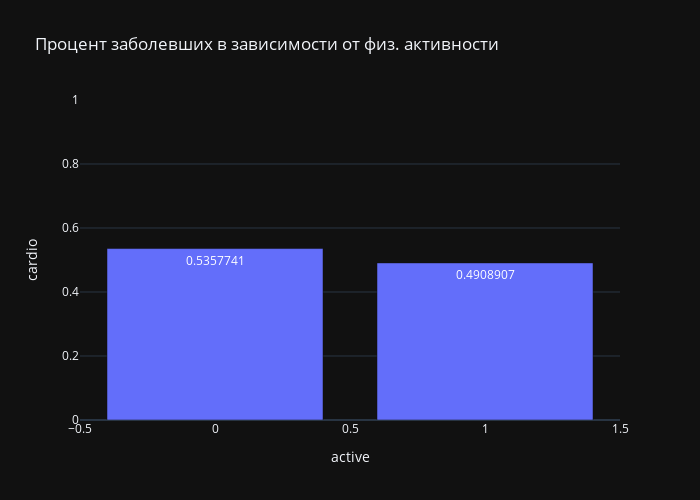

In [11]:
cardio_by_active = df_eda.pivot_table(index='active', values='cardio')

px.bar(
    cardio_by_active,
    x=cardio_by_active.index,
    y='cardio',
    title='Процент заболевших в зависимости от физ. активности',
    text_auto=True,
    range_y=(0, 1),
)

Физ. активность немного снижает риск болезни, хотя зависимость не сильная.

## age

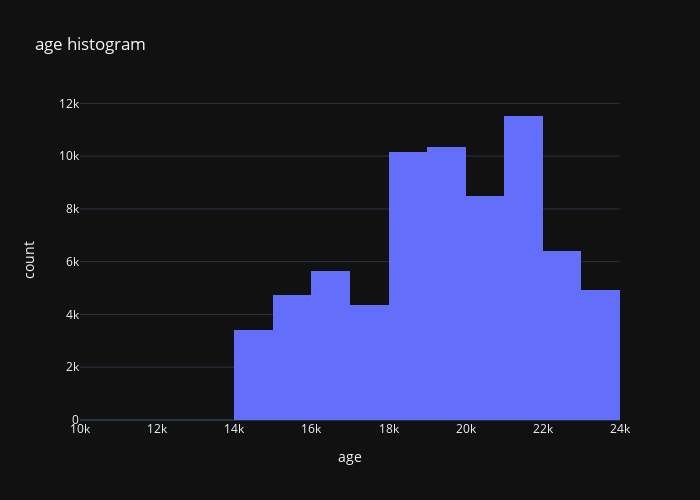

In [12]:
px.histogram(df_eda, x='age', nbins=25, title='age histogram')

Возраст, скорее всего, приводится в днях

In [13]:
print('Исходные данные:')
print(f'min = {df_eda["age"].min()}; max = {df_eda["age"].max()}')
print()

print('Если пересчитать в годы:')
print(
    f'min = {df_eda["age"].min() / 365:.1f}; max = {df_eda["age"].max() / 365:.1f}'
)

Исходные данные:
min = 10798; max = 23713

Если пересчитать в годы:
min = 29.6; max = 65.0


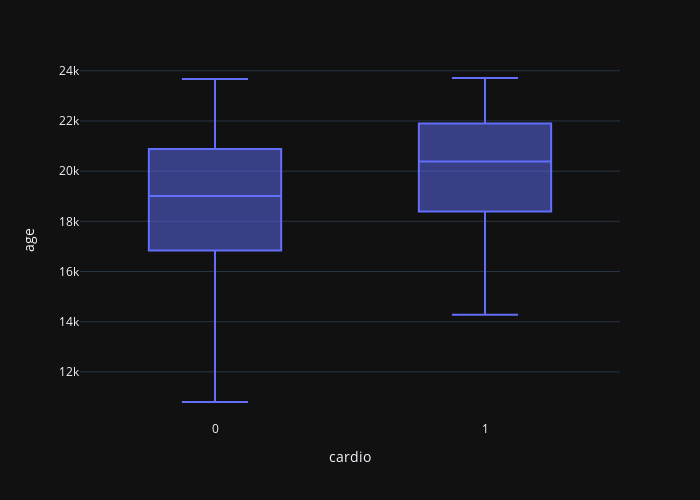

In [14]:
px.box(df_eda, x='cardio', y='age')

Чем старше человек - тем выше риск заболеть.

## alco

In [15]:
print('Кол-во пациентов по признаку alco')
print(df_eda['active'].value_counts())

Кол-во пациентов по признаку alco
1    56261
0    13739
Name: active, dtype: int64


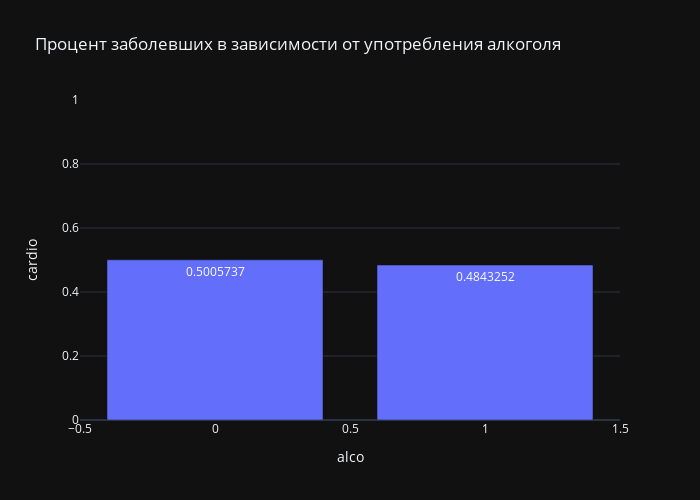

In [16]:
cardio_by_alco = df_eda.pivot_table(index='alco', values='cardio')

px.bar(
    cardio_by_alco,
    x=cardio_by_alco.index,
    y='cardio',
    title='Процент заболевших в зависимости от употребления алкоголя',
    text_auto=True,
    range_y=(0, 1),
)

## ap_hi

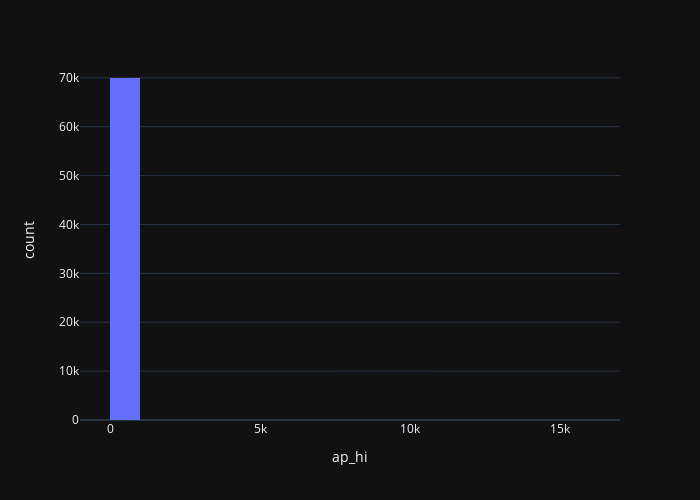

In [17]:
px.histogram(df_eda, x='ap_hi', nbins=20)

В данных явно есть выбросы. Отфильтруем

In [18]:
AP_HI__LOW = 80
AP_HI__HIGH = 220

df_ap_hi = make_pipeline(
    ml_pipe.OutliersToNAN('ap_hi', AP_HI__LOW, AP_HI__HIGH),
    ml_pipe.SimpleImputerMy('ap_hi'),
).fit_transform(df_eda)[['ap_hi', 'cardio']]

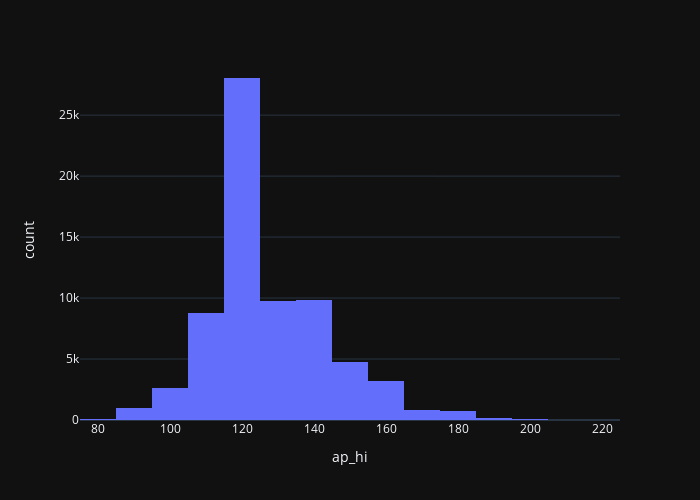

In [19]:
px.histogram(df_ap_hi, x='ap_hi', nbins=20)

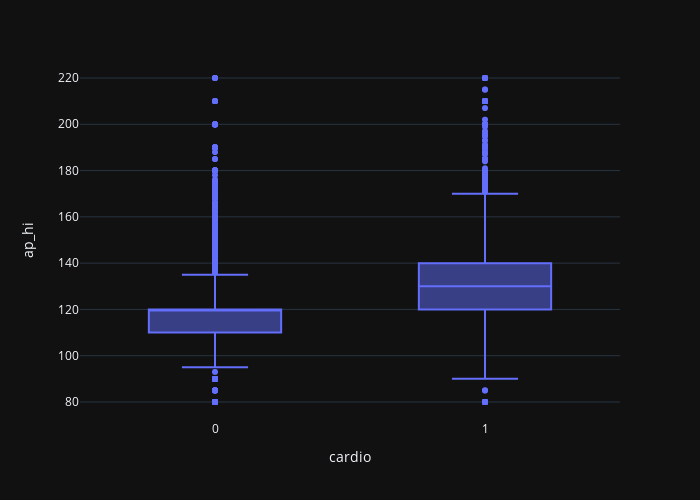

In [20]:
px.box(df_ap_hi, x='cardio', y='ap_hi')

Чем выше давление - тем выше заболеваемость.

## ap_lo

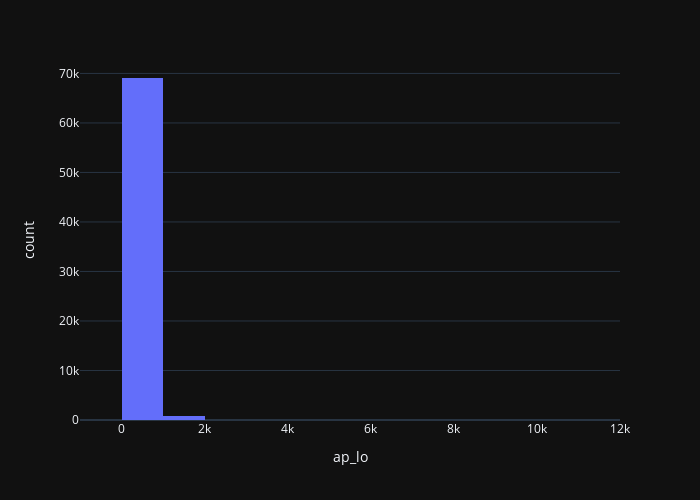

In [21]:
px.histogram(df_eda, x='ap_lo', nbins=20)

Аналогично верхнему давлению, здесь тоже есть выбросы.


In [22]:
AP_LO__LOW = 50
AP_LO__HIGH = 150

df_ap_lo = make_pipeline(
    ml_pipe.OutliersToNAN('ap_lo', AP_LO__LOW, AP_LO__HIGH),
    ml_pipe.SimpleImputerMy('ap_lo'),
).fit_transform(df_eda)[['ap_lo', 'cardio']]

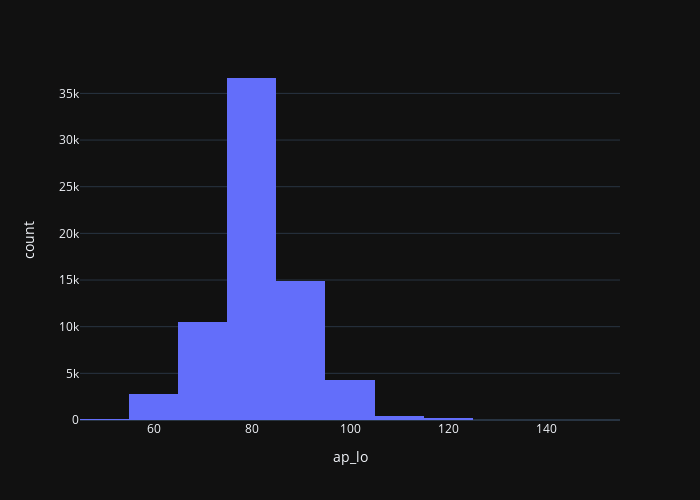

In [23]:
px.histogram(df_ap_lo, x='ap_lo', nbins=15)

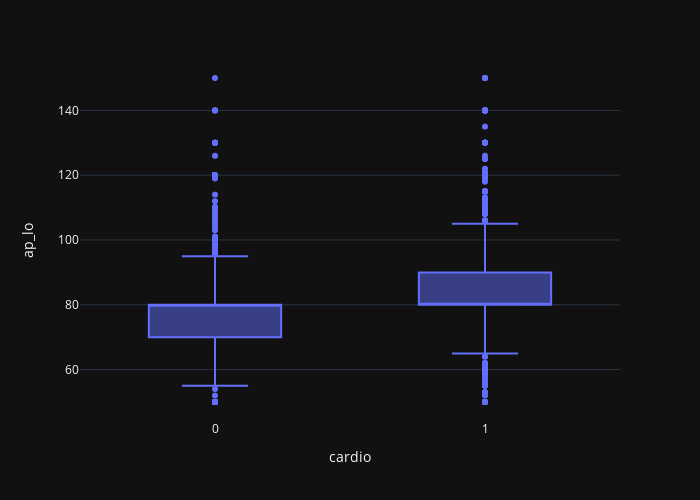

In [24]:
px.box(df_ap_lo, x='cardio', y='ap_lo')

## ap_lo vs ap_hi

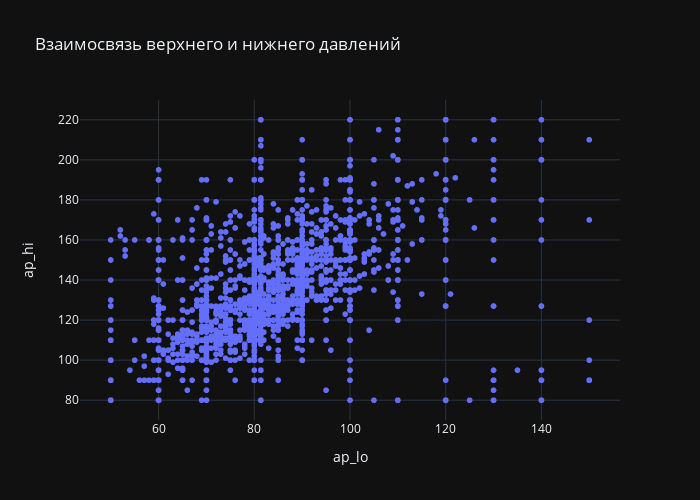

In [25]:
df_ap = pd.concat([df_ap_lo, df_ap_hi], axis='columns')

px.scatter(
    df_ap,
    x='ap_lo',
    y='ap_hi',
    title='Взаимосвязь верхнего и нижнего давлений',
)

In [26]:
print('Коэффициент корреляции:')
print(df_ap['ap_lo'].corr(df_ap['ap_hi']))

Коэффициент корреляции:
0.6880125878218956


## cholesterol

In [27]:
print('Кол-во пациентов по признаку cholesterol')
print(df_eda['cholesterol'].value_counts())

Кол-во пациентов по признаку cholesterol
1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64


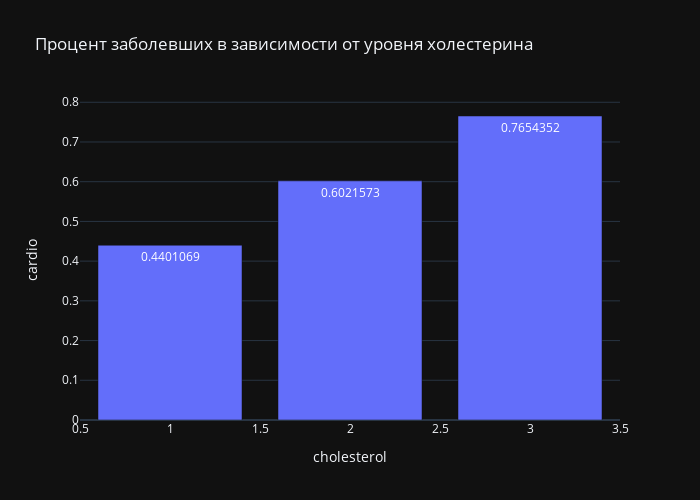

In [28]:
cardio_by_cholesterol = df_eda.pivot_table(
    index='cholesterol', values='cardio'
)

px.bar(
    cardio_by_cholesterol,
    x=cardio_by_cholesterol.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',
    text_auto=True
)

## id

In [29]:
df_eda['id'].nunique()

70000

Все элементы в этой колонке уникальны. Признак бесполезен

In [30]:
def pre_id(df: pd.DataFrame) -> pd.DataFrame:
    """Clean id column."""
    return df.drop(columns=['id'])

## gender

In [31]:
print('Кол-во пациентов по признаку gender')
print(df_eda['gender'].value_counts())

Кол-во пациентов по признаку gender
1    45530
2    24470
Name: gender, dtype: int64


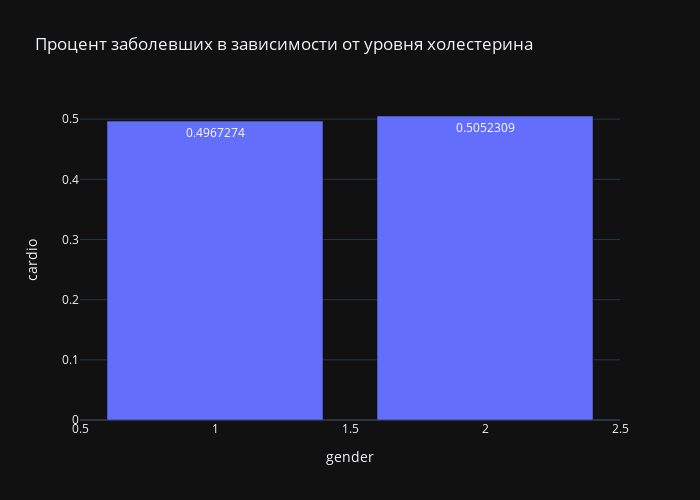

In [32]:
cardio_by_gender = df_eda.pivot_table(index='gender', values='cardio')

px.bar(
    cardio_by_gender,
    x=cardio_by_gender.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',
    text_auto=True
)

## gluc

In [33]:
print('Кол-во пациентов по признаку gluc')
print(df_eda['gluc'].value_counts())

Кол-во пациентов по признаку gluc
1    59479
3     5331
2     5190
Name: gluc, dtype: int64


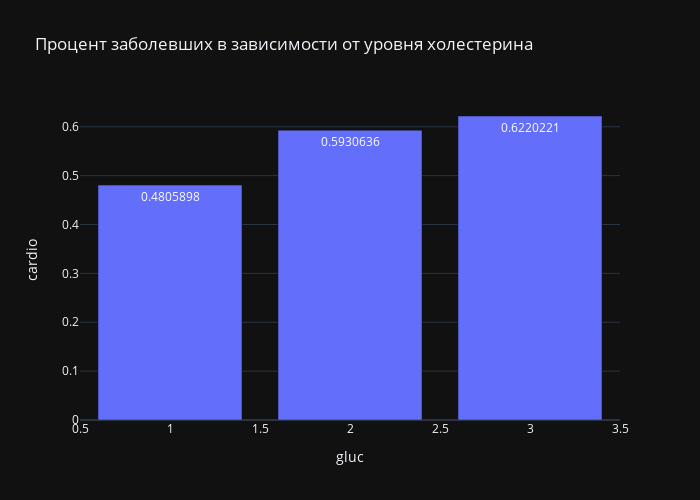

In [34]:
cardio_by_gluc = df_eda.pivot_table(index='gluc', values='cardio')

px.bar(
    cardio_by_gluc,
    x=cardio_by_gluc.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',  # TODO
    text_auto=True
)

## height

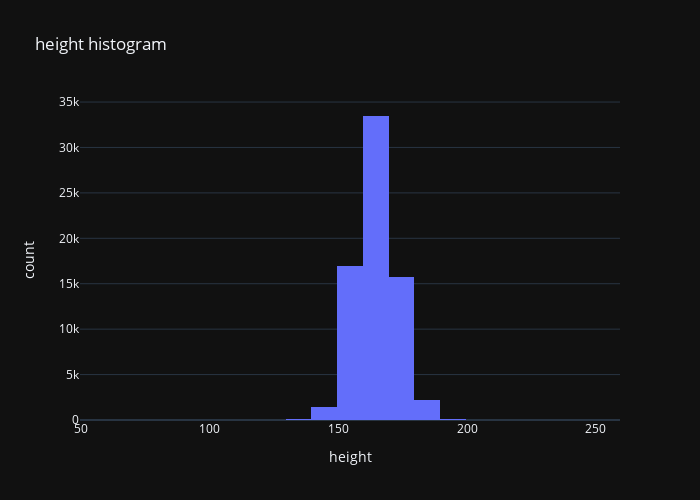

In [35]:
px.histogram(df_eda, x='height', nbins=25, title='height histogram')

In [36]:
HEIGHT__LOW = 140
HEIGHT__HIGH = 220

df_height = make_pipeline(
    ml_pipe.OutliersToNAN('height', HEIGHT__LOW, HEIGHT__HIGH),
    ml_pipe.SimpleImputerMy('height'),
).fit_transform(df_eda)

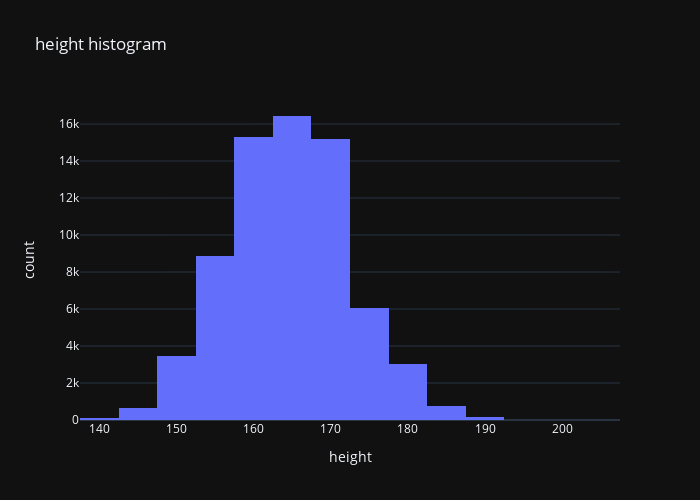

In [37]:
px.histogram(
    df_height, x='height', nbins=25, title='height histogram'
)

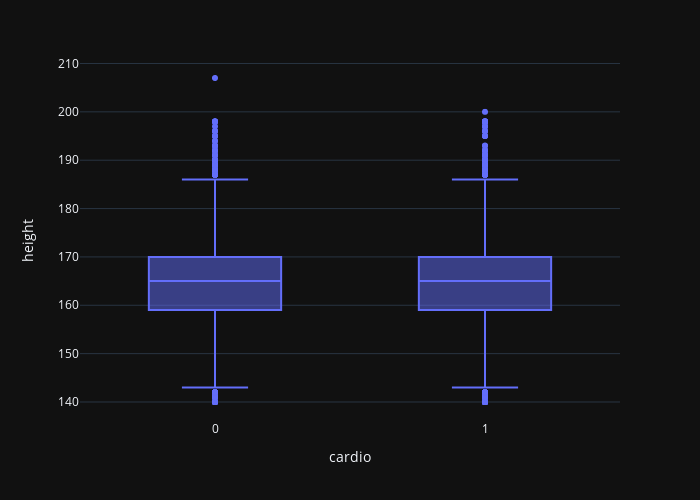

In [38]:
px.box(df_height, x='cardio', y='height')

От роста заболеваемость не зависит.

In [39]:
px.scatter(
    df_height,
    x='weight',
    y='height',
    title='Взаимосвязь верхнего и нижнего давлений',
)

print('Коэффициент корреляции:')
print(df_height['height'].corr(df_height['weight']))

Коэффициент корреляции:
0.3089151562883557


## smoke

In [40]:
print('Кол-во курящих / некурящих пациентов')
print(df_eda['smoke'].value_counts())

Кол-во курящих / некурящих пациентов
0    63831
1     6169
Name: smoke, dtype: int64


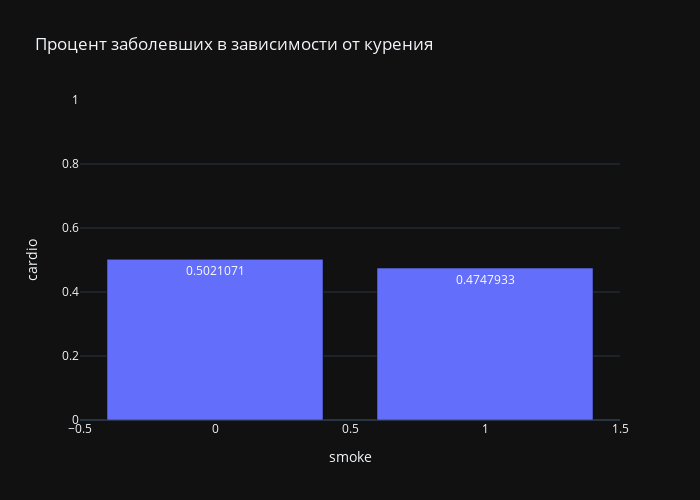

In [41]:
cardio_by_smoke = df_eda.pivot_table(index='smoke', values='cardio')

px.bar(
    cardio_by_smoke,
    x=cardio_by_smoke.index,
    y='cardio',
    title='Процент заболевших в зависимости от курения',
    text_auto=True,
    range_y=(0, 1),
)

## weight

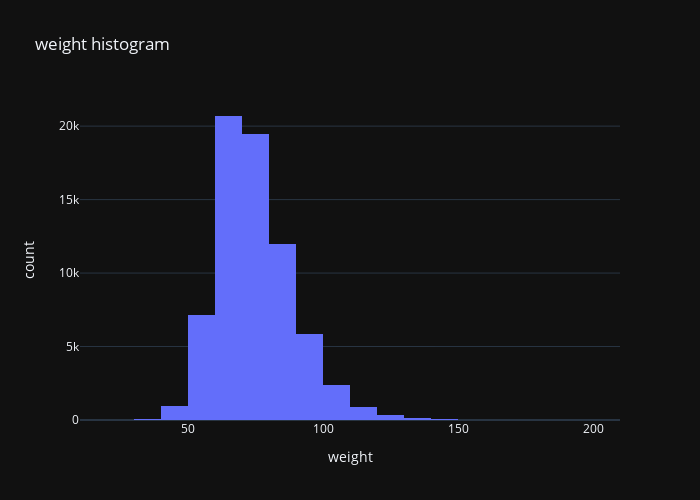

In [42]:
px.histogram(df_eda, x='weight', nbins=25, title='weight histogram')

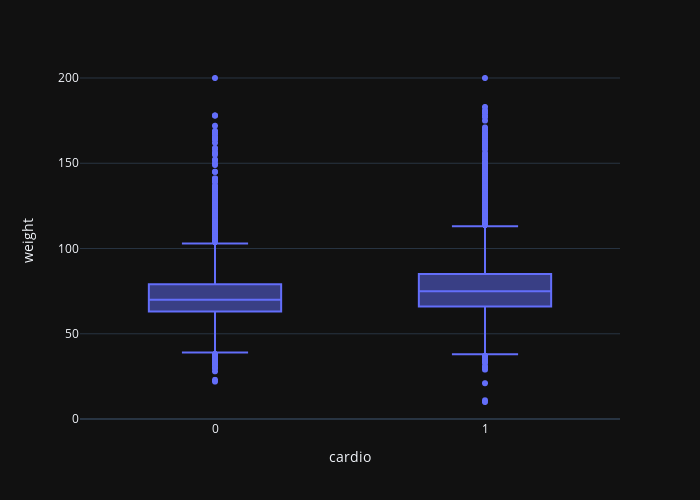

In [43]:
px.box(df_eda, x='cardio', y='weight')

# Preprocess


Выделим целевой признак

In [44]:
FEATURES = ['active', 'age', 'alco', 'ap_hi', 'ap_lo', 'cholesterol', 'gender',
            'gluc', 'height', 'smoke', 'weight']
FEATURES_SCALE = ['age', 'ap_hi', 'ap_lo', 'height', 'weight', 'cholesterol', 'gluc', ]
# FEATURES_ENCODE = ['cholesterol', 'gluc', ]

TARGET = 'cardio'

df = load_train()
X = df[FEATURES]
y = df[TARGET]

In [45]:
pipe_preprocess = make_pipeline(
    ml_pipe.OutliersToNAN('ap_hi', AP_HI__LOW, AP_HI__HIGH),
    ml_pipe.OutliersToNAN('ap_lo', AP_LO__LOW, AP_LO__HIGH),
    ml_pipe.OutliersToNAN('height', HEIGHT__LOW, HEIGHT__HIGH),
    ml_pipe.IterativeImputerPd(['ap_hi', 'ap_lo']),
    ml_pipe.IterativeImputerPd(['height', 'weight']),
    ml_pipe.SimpleImputerMy(['ap_hi', 'ap_lo', 'height']),
    # ml_pipe.OneHotEncoderMy(FEATURES_ENCODE),
    ml_pipe.StandardScalerMy(FEATURES_SCALE),
)
display(
    pipe_preprocess.fit_transform(X).head(20)
)

,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight
0,1,-0.436062,0,-0.998887,-0.159000,-0.539322,2,-0.395720,0.452741,0,-0.847873
1,1,0.307686,0,0.762207,0.882317,2.400793,1,-0.395720,-1.084075,0,0.749831
2,0,-0.247997,0,0.175176,-1.200316,2.400793,1,-0.395720,0.068537,0,-0.708942
3,1,-0.748152,0,1.349238,1.923633,-0.539322,2,-0.395720,0.580809,0,0.541435
4,0,-0.808543,0,-1.585918,-2.241632,-0.539322,1,-0.395720,-1.084075,0,-1.264666
5,0,0.991043,0,-0.411856,-0.159000,0.930735,1,1.351719,-1.724415,0,-0.500546
6,1,1.071700,0,0.175176,-0.159000,2.400793,1,-0.395720,-0.956007,0,1.305554
7,1,1.262602,0,0.175176,0.882317,2.400793,2,3.099157,1.733422,0,1.444485
8,1,-0.729913,0,-0.998887,-1.200316,-0.539322,1,-0.395720,-0.827939,0,-0.222685
9,0,0.147993,0,-0.998887,-2.241632,-0.539322,1,-0.395720,-0.059531,0,-0.431081


# Models


В качестве метрики оптимизации выберем ROC AUC.

In [46]:
METRIC_FOR_OPTIM = 'roc_auc'

## Dummy

In [47]:
model_dummy = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', DummyClassifier(
            random_state=1,
        )),
    ]
)
params = {
    'model__strategy': ['most_frequent', 'prior', 'stratified', 'uniform']
}
cv_dummy = RandomizedSearchCV(
    estimator=model_dummy,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
cv_dummy.fit(X, y)

print(cv_dummy.best_score_)
print(cv_dummy.best_params_)

/home/konstantin/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



0.5009591144966483
{'model__strategy': 'stratified'}


## LogisticRegression

In [48]:
model_logreg = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', LogisticRegression(
            n_jobs=-1,
            random_state=1,
            max_iter=1000,
        )),
    ]
)
params = {
    'model__C': stats.uniform(0.1, 2.0),
}
cv_logreg = RandomizedSearchCV(
    estimator=model_logreg,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
cv_logreg.fit(X, y)

print(cv_logreg.best_score_)
print(cv_logreg.best_params_)

0.7918508425610178
{'model__C': 0.10022874963468978}


In [49]:
model_logreg.set_params(**cv_logreg.best_params_)
model_logreg.fit(X, y)
print(
    'Метрики на обучающей выборке:',
    cross_val_score(model_logreg, X, y, scoring=METRIC_FOR_OPTIM)
)

Метрики на обучающей выборке: [0.78659799 0.79543369 0.79492014 0.79504593 0.78725646]


## RandomForest

In [50]:
model_rfc = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', RandomForestClassifier(
            n_estimators=20,
            n_jobs=-1,
            random_state=1,
        )),
    ]
)
params = {
    'model__max_depth': range(4, 20),
}
cv_rfc = RandomizedSearchCV(
    estimator=model_rfc,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
cv_rfc.fit(X, y)

print(cv_rfc.best_score_)
print(cv_rfc.best_params_)

0.8000966946058308
{'model__max_depth': 10}


In [51]:
model_rfc.set_params(**cv_rfc.best_params_)
model_rfc.fit(X, y)
print(
    'Метрики на обучающей выборке:',
    cross_val_score(model_rfc, X, y, scoring=METRIC_FOR_OPTIM)
)

Метрики на обучающей выборке: [0.79674366 0.80510432 0.80164797 0.8016005  0.79538703]


## HistGradientBoosting

In [52]:
model_boost = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', HistGradientBoostingClassifier(
            random_state=1,
        )),
    ]
)
params = {
    'model__max_iter': [20000],
    'model__learning_rate': stats.uniform(0.001, 0.1),
    'model__max_depth': range(5, 100, 5),
    'model__l2_regularization': stats.uniform(0, 10.0),
    'model__max_bins': [255],
}
cv_boost = RandomizedSearchCV(
    estimator=model_boost,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
cv_boost.fit(X, y)

print(cv_boost.best_score_)
print(cv_boost.best_params_)

0.8028323343368411
{'model__l2_regularization': 9.355390708060318, 'model__learning_rate': 0.08563109166860172, 'model__max_bins': 255, 'model__max_depth': 30, 'model__max_iter': 20000}


In [53]:
model_boost.set_params(**cv_boost.best_params_)
model_boost.fit(X, y)
print(
    'Метрики на обучающей выборке:',
    cross_val_score(model_boost, X, y, scoring=METRIC_FOR_OPTIM)
)

Метрики на обучающей выборке: [0.7984377  0.80710797 0.8048277  0.80474177 0.79904653]


## Stacking

In [ ]:
model_stack = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', StackingClassifier(
            estimators=[
                ('logreg', LogisticRegression(
                    random_state=1,
                )),
                ('rfc', RandomForestClassifier(
                    random_state=1,
                ))
            ],
            final_estimator=HistGradientBoostingClassifier(
                random_state=1,
            )
        )),
    ]
)
params = {
    'model__rfc__max_depth': range(4, 20),
    'model__final_estimator__learning_rate': stats.uniform(0.001, 0.2),
    'model__final_estimator__max_iter': [40000],
    'model__final_estimator__max_depth': range(4, 10),
    'model__final_estimator__l2_regularization': stats.uniform(0, 10.0),
}
cv_stack = RandomizedSearchCV(
    estimator=model_stack,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    cv=5,
    n_iter=40,
)
cv_stack.fit(X, y)

print(cv_stack.best_score_)
print(cv_stack.best_params_)

## XGBoost


In [55]:
model_xgboost = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', XGBClassifier(
            seed=1,
            eval_metric='auc',
            learning_rate=0.3,
        )),
    ]
)
params = {
    'model__max_depth': range(4, 6),
}
# cv_xgboost = RandomizedSearchCV(
#     estimator=model_xgboost,
#     param_distributions=params,
#     random_state=1,
#     n_jobs=-1,
#     scoring=METRIC_FOR_OPTIM,
#     cv=3,
# )
# cv_xgboost.fit(X, y)
# print(cv_xgboost.best_score_)
# print(cv_xgboost.best_params_)

## CatBoost


In [56]:
model_catboost = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', CatBoostClassifier(
            random_state=1,
            verbose=False,
        )),
    ]
)
params = {
    'model__max_depth': [4, 7, 10],
    'model__l2_leaf_reg': [1, 4, 9],
    'model__learning_rate': [0.03, 0.1, 0.15],
    'model__iterations': [300],
}
# cv_catboost = RandomizedSearchCV(
#     estimator=model_catboost,
#     param_distributions=params,
#     random_state=1,
#     n_jobs=-1,
#     scoring=METRIC_FOR_OPTIM,
#     cv=3,
# )
# cv_catboost.fit(X, y)
# print(cv_catboost.best_score_)
# print(cv_catboost.best_params_)

In [57]:
# model_catboost.set_params(**cv_catboost.best_params_)
# model_catboost.fit(X, y)

# Inspection


## Permutation importance

In [58]:
result = permutation_importance(
    estimator=model_logreg,
    X=X,
    y=y,
    n_repeats=10,
    random_state=1,
)
display(
    ml_pipe.display_permutation_importance(
        result=result,
        x_columns=X.columns,
    )
)

,feature,mean,std
3,ap_hi,0.134304,0.001532
5,cholesterol,0.025077,0.000868
1,age,0.015834,0.000709
10,weight,0.004344,0.000707
4,ap_lo,0.004306,0.000406
0,active,0.001747,0.000374
7,gluc,0.000700,0.000260
2,alco,0.000557,0.000183
9,smoke,0.000309,0.000225
6,gender,0.000066,0.000118


## Shap


Permutation explainer: 101it [00:16,  2.36it/s]                         


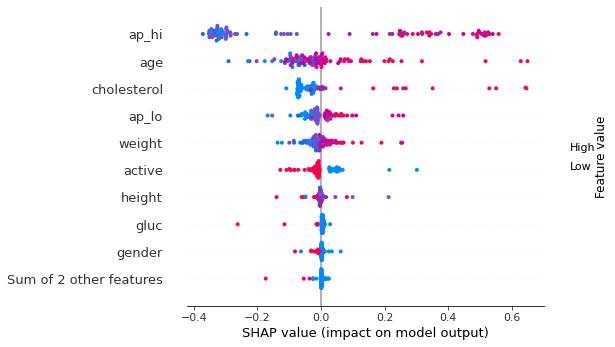

In [59]:
X_shap = model_boost[:-1].transform(X).sample(n=100, random_state=1)

shap_explainer = shap.Explainer(
    model=model_boost[-1].predict,
    masker=X_shap,
)
shap_values = shap_explainer(X_shap)

shap.plots.beeswarm(shap_values)

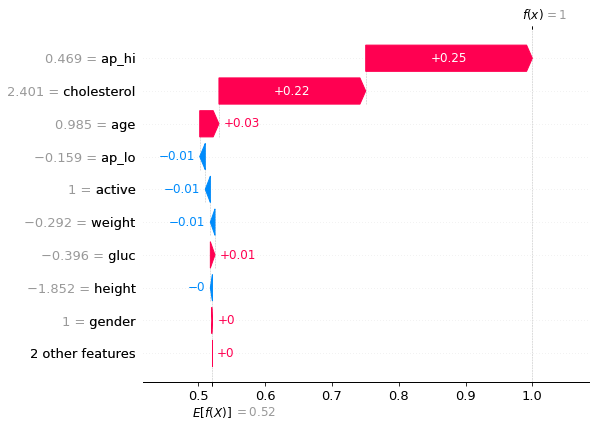

In [60]:
patient_with_cardio = {
    'active': 1,
    'age': 60 * 365,
    'alco': 0,
    'ap_hi': 135,
    'ap_lo': 80,
    'cholesterol': 3,
    'gender': 1,
    'gluc': 1,
    'height': 150,
    'smoke': 0,
    'weight': 70,
}
patient_with_cardio = model_boost[:-1].transform(pd.DataFrame([patient_with_cardio]))
shap.plots.waterfall(shap_explainer(patient_with_cardio)[0])

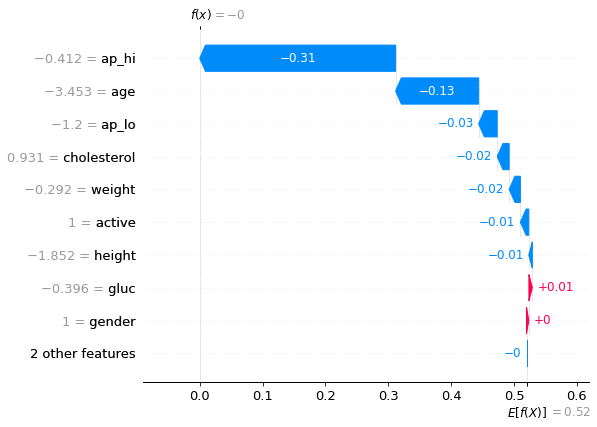

In [61]:
patient_without_cardio = {
    'active': 1,
    'age': 30 * 365,
    'alco': 0,
    'ap_hi': 120,
    'ap_lo': 70,
    'cholesterol': 2,
    'gender': 1,
    'gluc': 1,
    'height': 150,
    'smoke': 0,
    'weight': 70,
}
patient_without_cardio = model_boost[:-1].transform(pd.DataFrame([patient_without_cardio]))
shap.plots.waterfall(shap_explainer(patient_without_cardio)[0])

# Submission

In [62]:
model_for_submit = model_boost

df_subm = load_test()

submission = pd.DataFrame(
    data=model_for_submit.predict(df_subm[FEATURES]),
    index=df_subm['id'],
    columns=[TARGET],
).to_csv('../data/my_submission.csv')
